## import all the stuff

In [1]:
%gui qt
%matplotlib inline
from PIL import Image
from csbdeep.utils import Path, normalize
from glob import glob
from magicgui import magicgui
from magicgui.widgets import Label, SpinBox, PushButton, Text, Container
from manager.acquisition import acq, acq_stim, acq_multi, acq_multi_dark, acq_mask
from manager.dmd import dmd
from manager.fov import FOV
from manager.preset import preset
from manager.stage import load_pos_file, get_pos_from_mm, stage_position
from matplotlib import pyplot as plt 
from multiprocessing import Process
from napari.layers import Image, Labels
from napari.qt import thread_worker

from pycromanager import Bridge

from skimage import io

#from sklearn.ensemble import RandomForestClassifier
#from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
#from stardist.models import StarDist2D
from tqdm import tqdm


import math
import matplotlib
import matplotlib.pyplot as plt
import napari
import nest_asyncio
import numpy as np
import pandas as pd
import pickle as pkl
import queue

import threading
import time
import trackpy as tp
from tqdm import tqdm
#matplotlib.rcParams["image.interpolation"] = None
nest_asyncio.apply()

## Setup connection with micro manager

In [2]:
bridge = Bridge() #connection to micro-manager
core = bridge.get_core()
studio = bridge.get_studio()
print(bridge.get_core())
dmd = dmd(core) #init dmd device

## Set up basic microscope config (light path, hardware triggering, binning etc)

In [3]:
nidaq_setup = preset(core) #focus preset
nidaq_setup.settings = [

    ["Spectra RIGHT","Teal_Level",100],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Level",100],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Level",100],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Level",100],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Level",100],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Level",100],
    ["Spectra RIGHT","Red_Enable",0],

    ["Spectra RIGHT","White_Enable",0],
    ['Andor sCMOS LEFT','AuxiliaryOutSource (TTL I/O)','FireAny']
]
nidaq_setup.apply_no_retry()

camera_setup = preset(core) #focus preset
camera_setup.settings = [
    ["Andor sCMOS LEFT","Binning",'2x2'],
    #["Andor sCMOS LEFT","Sensitivity/DynamicRange",'12-bit (low noise)'],
    #["Andor sCMOS LEFT","Exposure",'300'],
    #["Andor sCMOS LEFT","TriggerMode",'Software (Recommended for Live Mode)'],
    ["TILightPath","State",'2'],
    ["Mosaic3","TriggerMode",'InternalExpose'], #InternalSoftware
    #["Andor sCMOS LEFT","PixelReadoutRate",'200 MHz - lowest noise'],
]

camera_setup.apply(core)

Andor sCMOS LEFT: Set Binning to 2x2
TILightPath: Set State to 2
Mosaic3: Set TriggerMode to InternalExpose


In [4]:
expose_UV = preset(core)
# 555/25 with same filterwheel as H2B or 575 with 2/2
expose_UV.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",1],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "1"],#2 
    ["Wheel-C", "State", 1],# could also use 1 # standard  2
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Violet_Level",100] #25
]
expose_UV.camera_exposure_time = 250 #150
expose_UV.dmd_exposure_time = 150
expose_UV.name = 'expose_UV'
expose_UV.apply(core)
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 1
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 1


Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Violet_Level to 100


## Actin channel (red laser)

In [5]:
check_RED = preset(core)
#IRFP
check_RED.settings = [ # Actin used for segmentation
    ["TIFilterBlock1", "State", "1"],
    ["Wheel-C", "State", 2],  # filter no 2 lets red light through - needed to check with reflected light
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],

    ["Spectra RIGHT","Red_Enable",1],
    ["Spectra RIGHT","Red_Level",50] #75
    
]
check_RED.camera_exposure_time = 5 #500
check_RED.dmd_exposure_time = 250
check_RED.name = "check_RED"
check_RED.apply()
dmd.all_on()
#dmd.checker_board()


In [6]:
dmd.all_off()

## Turn off all lights

In [7]:
black = preset(core)
black.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["Wheel-C", "State", 0],
]
black.name = 'BLACK'
black.apply()

### Add all channels to the list that should show up in interface

In [8]:
channels = [expose_UV,check_RED,black]

## NAPARI LIVE VIEW

### Settings (running this deletes all positions)

In [9]:
# data acquired on microscope or simulated?
simulate = False
clip =[1024, 1024]
# um / px, for correct scaling in napari
size_um = [0.16, 0.16]
#Time between checking again if new image is available
sleep_time = 0.05
# contrast limits for display
clim = [0, 300]

# initialize global variables
# flag to break while loops
acq_running = False
# empty queue for image data and z positions
img_queue = queue.Queue()
# xyz data stack
data = np.random.rand(clip[0], clip[1]) * clim[1]
zmq_lock = threading.Lock()
position_list = []

### Open napari live-view

In [10]:
import cv2
font = cv2.FONT_HERSHEY_DUPLEX
checker_board = np.kron([[1, 0] * 20, [0, 1] * 20] * 20, np.ones((20, 20))) #https://stackoverflow.com/a/37440123
startup_screen = checker_board*100
cv2.putText(startup_screen,'github.com/hinderling',(40,780), font, 2,(255),2)
#plt.imshow(startup_screen)
data = startup_screen

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    zmq_lock.release()
    if remaining_image_count < 1:
        print('No image in uManager queue.')
        time.sleep(0.5)
        return
    
    zmq_lock.acquire()
    array = core.get_last_image()
    #core.clear_circular_buffer()
    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[:,:]
    img_queue.put([channels[1], img])
    return

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    if remaining_image_count < 1:
        zmq_lock.release()
        print('Warning: No image in uManager queue.')
        time.sleep(0.5)
        return
    try:
        array = core.get_last_image()
    except:
        print('ERROR: No image in uManager queue.')
        time.sleep(0.5)
        return

    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[::,::]
    img_queue.put([channels[1], img])
    return

def display_napari(image):
    """ Unpacks z position and reshapes image from pos_img. Writes image into correct
        slice of data, and updates napari display.
        Called by worker thread yielding elements from queue.
        Needs to be in code before worker thread connecting to it.
        Inputs: array pos_img: queue element containing z position and raveled image data.
        Global variables: np.array data: contains image stack
            img_queue: needed only to send task_done() signal.
    """
    global data
    global img_queue
    channel = image[0]
    image= image[1]
    layers[0].data = image
    img_queue.task_done()

@thread_worker
def append_img(img_queue):
    """ Worker thread that adds images to a list.
        Calls either micro-manager data acquisition or functions for simulating data.
        Inputs: img_queue """

    # start microscope data acquisition
    print('Worker started: append_img')
    if not simulate:
         while acq_running:
            acquire_data()
            time.sleep(sleep_time)

    # run with simulated data
    else:
        ii = 0
        while acq_running:
            simulate_data(ii)
            ii = ii + 1
            #print("appending to queue", ii)
            time.sleep(sleep_time)


@thread_worker(connect={'yielded': display_napari})
def yield_img(img_queue):
    """ Worker thread that checks whether there are elements in the
        queue, reads them out.
        Connected to display_napari function to update display """
    print('Worker started: yield_img')
    global acq_running
    
    #time_last_frame = time.time()
    #print('yield image')
    
    #print(acq_running)
    while acq_running:
        #time.sleep(sleep_time)
        # get elements from queue while there is more than one element
        # playing it safe: I'm always leaving one element in the queue
        img_queue_size = img_queue.qsize()
        #print(img_queue_size)
        while img_queue.qsize() > 0:
           # print("reading from queue ", img_queue.qsize())
            yield img_queue.get(block = False)
            #time_this_frame = time.time()
            #time_diff = time_this_frame - time_last_frame
            #fps = int(1/time_diff)
        time.sleep(sleep_time)

    # read out last remaining elements after end of acquisition
    while img_queue.qsize() > 0:
        yield img_queue.get(block = False)
    print("acquisition done")
@magicgui(call_button = "Start")
def start_acq():
    """ Called when Start button in pressed. Starts workers and resets global variables"""
    print("starting threads...")
    global acq_running
    global channels
    global zmq_lock
    if not acq_running:
        #z_range[3] = 0
        acq_running = True
        zmq_lock.acquire()
        core.start_continuous_sequence_acquisition(0)
        zmq_lock.release()
        worker1 = append_img(img_queue)
        worker2 = yield_img(img_queue)
        worker1.start()
        #worker2.start() # doesn't need to be started bc yield is connected
    else:
        print("acquisition already running!")

threshold = 100

@magicgui(slider_float={"widget_type": "FloatSlider", 'max': 1000})
def set_treshold(slider_float=100):
    global threshold
    threshold = slider_float

@magicgui(call_button = "Stop")
def stop_acq():
    print("stopping threads")
    # set global acq_running to False to stop other workers
    global acq_running
    global core
    global zmq_lock
    
    zmq_lock.acquire()
    core.stop_sequence_acquisition()    
    zmq_lock.release()
    acq_running = False

    
#a channel is a preset that has EXPOSURE and POWER function
channels_widget = Container()
channels_widgets_list = []
for channel in channels:
    @magicgui(
    call_button = 'SELECT',
    auto_call=False,
    label = {"widget_type": "Label","name":"label","label":channel.name},
    power={"widget_type": "SpinBox","name":"power" ,"label":'%',"min":0,"max": 100},
    exposure={"widget_type": "SpinBox","name":"ms" ,"label":'ms',"min":1,"max": 10000},
    #mode={"choices": ["reflect", "constant", "nearest", "mirror", "wrap"]},
    layout='horizontal',
    channel={'bind': channel} #replace this with channel 
    )
    def channel(label, power: int = channel.settings[-1][2], exposure=channel.camera_exposure_time, channel = channel):
        global channels
        print(channel.name)
        stop_acq()
        channel.camera_exposure_time = exposure
        channel.set_power(power)
        zmq_lock.acquire()
        channel.apply()
        dmd.all_on()
        zmq_lock.release()
        start_acq()
    channels_widgets_list.append(channel)

channels_widget = Container(widgets=(channels_widgets_list))
        
@magicgui(call_button = "Store position")
def store_pos():
    global channels
    global zmq_lock
    global acq_running
    global position_list
    restart = False
    if acq_running:
        stop_acq()
        restart = True
    zmq_lock.acquire()
    point = core.get_xy_stage_position()
    pfs_offset = core.get_auto_focus_offset()
    x = point.get_x()
    y = point.get_y()
    zmq_lock.release()
    position_list.append(stage_position(x,y,pfs_offset))
    if restart:
        start_acq()    
        
        

@magicgui(call_button = "DMD Checkerboard pattern")
def set_dmd_checkerboard():
    stop_acq()
    zmq_lock.acquire()
    dmd.checker_board()
    zmq_lock.release()
    start_acq()
        
        
# check if viewer is already open
# if yes: close and reopen
try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
viewer = napari.Viewer(ndisplay=2)

# initialize napari viewer with stack view and random data, reslice view
#scale = [(z_range[1]-z_range[0])/z_range[2]*z_scale, size_um[1], size_um[0]]
layers = [viewer.add_image(data,
                        name = 'zero',
                        colormap = 'gray',
                        interpolation = 'nearest',
                        blending = 'additive',
                        rendering = 'attenuated_mip',
                        #scale = scale,
                        contrast_limits = clim)
         ]

#viewer.dims._roll()
viewer.window.add_dock_widget(start_acq,area='left')
viewer.window.add_dock_widget(stop_acq,area='left')
viewer.window.add_dock_widget(channels_widget,area='left') 
viewer.window.add_dock_widget(set_dmd_checkerboard,area='left')
viewer.window.add_dock_widget(store_pos,area='left')

viewer.text_overlay.visible = True
#viewer.window.qt_viewer.canvas.measure_fps(callback=update_fps)   


viewer already closed or never opened


C:\Users\micro-manager\AppData\Local\Temp\ipykernel_668\451363266.py:257: DeprecationWarning: Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The argument 'interpolation' was deprecated in 0.4.17 and it will be removed in 0.6.0.
  layers = [viewer.add_image(data,


## Load affine transformation matrix from disk

the last one worked well so just load it from file (`affine_60x_2bin_CYAN.npy`)

### Do a new calibration:

TIFilterBlock1: Set State to 1
Wheel-C: Set State to 2
Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 1
Spectra RIGHT: Set Red_Level to 50


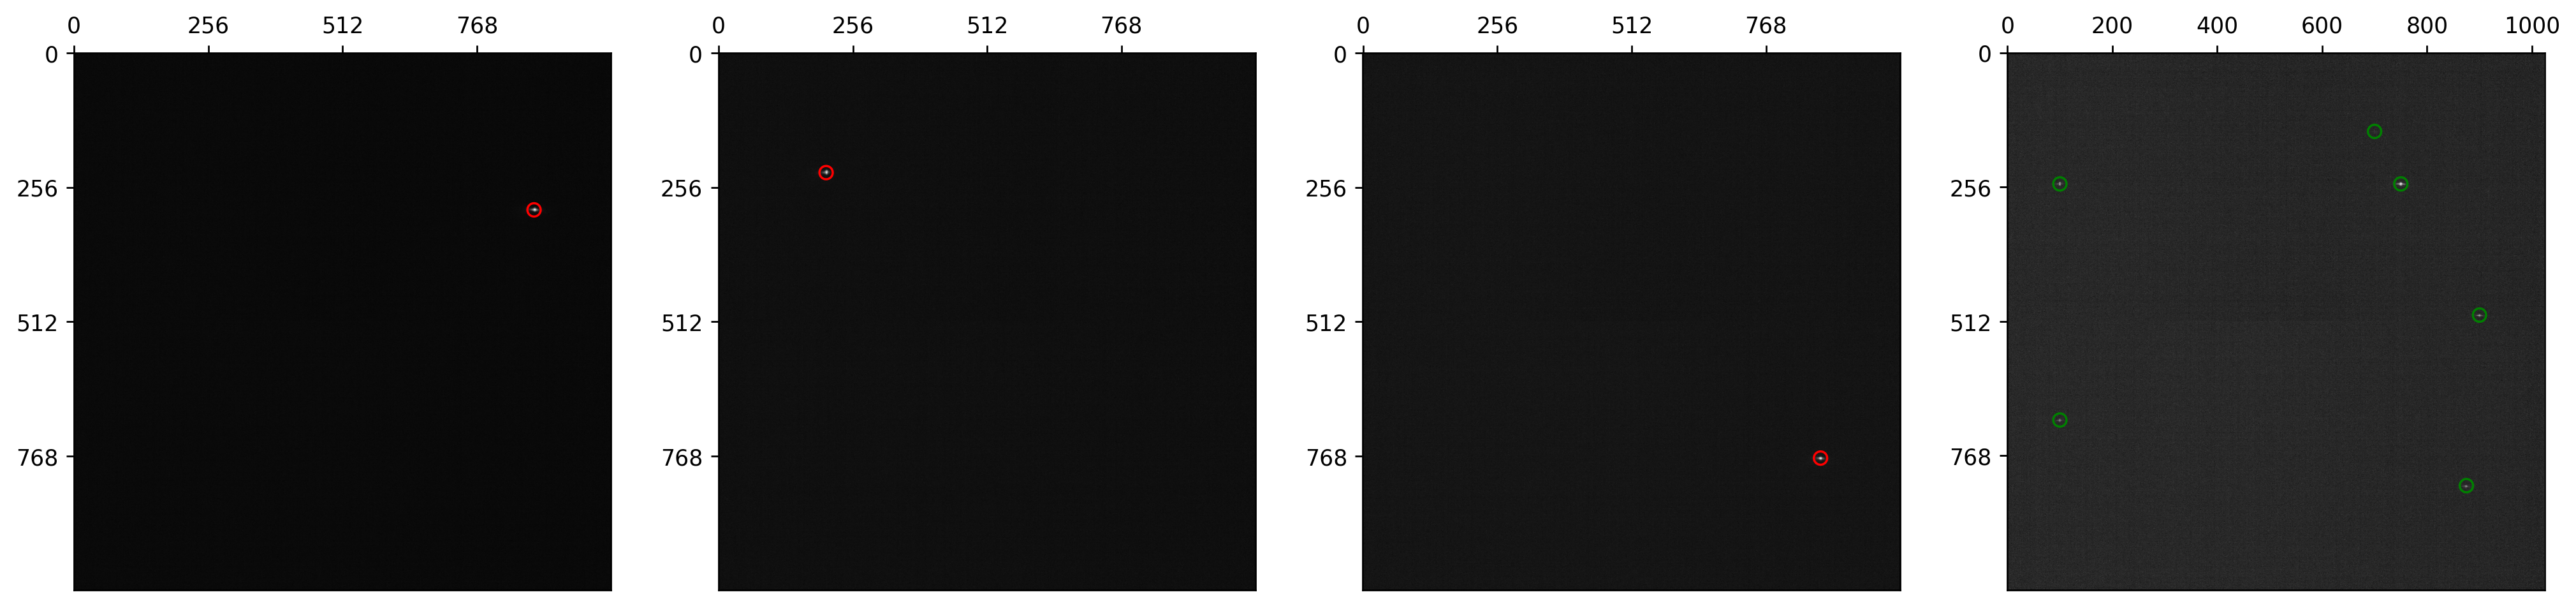

In [17]:
check_RED.apply(core)
affine = dmd.calibrate(verbous = True, blur = 1, circle_size = 2, marker_style = 'o')

In [ ]:
np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_10x_dmd_micropatterning.npy"), affine)

### Load an old calibration

In [ ]:
#affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_CYAN.npy")
#affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM.npy")
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_60x_2bin_CYAN.npy")

In [ ]:
affine ## this should print some numbers

In [ ]:
io.imsave("C:\\Users\\micro-manager\\Desktop\\after_seelction_erk-ktr_expression.tiff", frame)

## Manually stimulate from masks in napari viewer

In [ ]:
from skimage.draw import polygon

#viewer = napari.Viewer()
#stack_raw_c0_layer = viewer.add_image(np.zeros((1024,1024)), rgb=False,contrast_limits = (0,2000))
building = np.array([[310, 382], [229, 381], [209, 401], [221, 411]])
shapes_layer = viewer.add_shapes([building], shape_type='polygon', edge_width=5,edge_color='coral', face_color='royalblue')



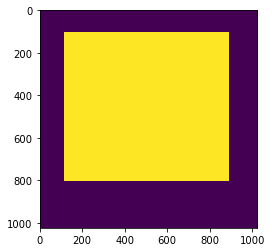

In [46]:

def polygons_to_array(shapes_layer):
    '''Takes as input a napari shapes layer with polygons, and returns a binary array where polygon areas are 1 and background is 0'''
    img = np.zeros((1024, 1024), dtype=np.uint8)
    shapes = shapes_layer.data
    for shape in shapes:
        r = shape[:,0]
        c = shape[:,1]
        rr, cc = polygon(r, c)
        img[rr, cc] = 1
    return img

manual_stim = polygons_to_array(shapes_layer)
plt.imshow(manual_stim)

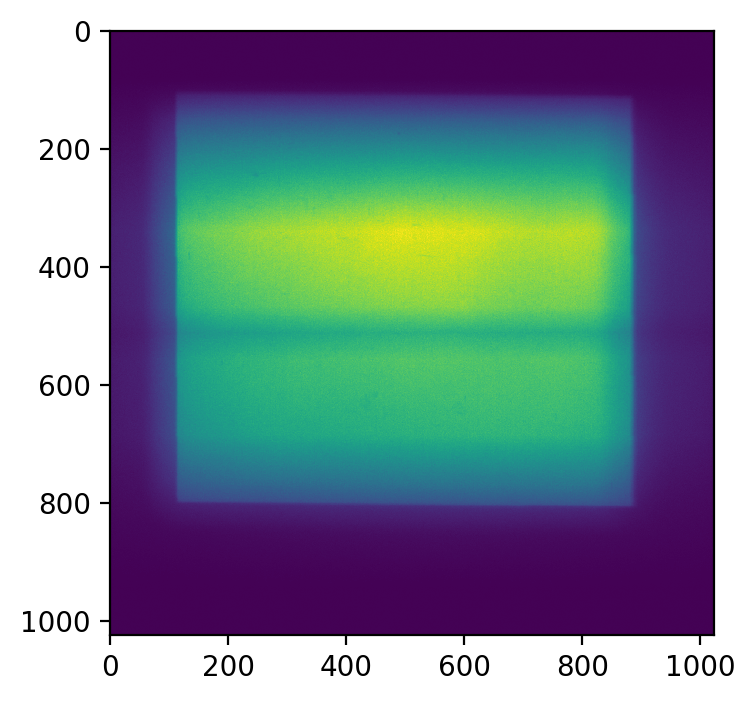

In [47]:
#expose_UV.camera_exposure_time = int(150*4)
stim_img = acq_stim(manual_stim,check_RED,affine,dmd)
plt.figure(dpi = 200)
plt.imshow(stim_img)

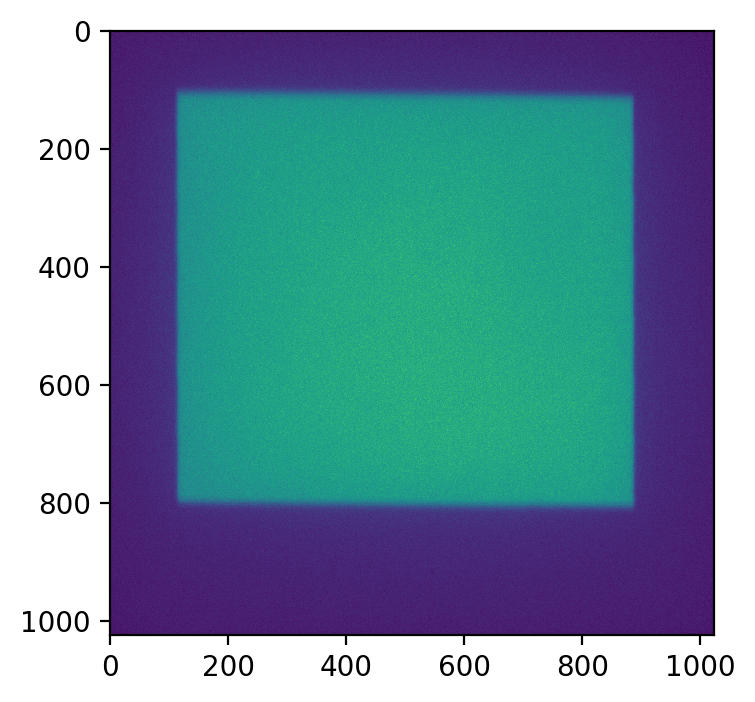

stopping threads


In [48]:
expose_UV.camera_exposure_time = int(250)
stim_img = acq_stim(manual_stim,expose_UV,affine,dmd)
plt.figure(dpi = 200)
plt.imshow(stim_img)

### helper functions to load and preprocess mask images

In [11]:
def load_mask(name,invert = False,crop=False):
    # mask = io.imread(Path('Z:/PertzLab/rberthoz/masks/', f'{name}.png'))[:, :]
    #mask = io.imread(Path('Z:/mic01-imaging/Alex/', f'{name}.png'))[:, :]
    mask = io.imread(Path('Z:/jfrei/Micropatterning/Patterns/', f'{name}.png'))[:, :, 0]


    #mask = io.imread(Path('Z:/PertzLab/Ben/patttteeeeern/', f'{name}.png'))[:, :, 0]

    if (invert):
        mask = ~mask
        mask = (mask>=128).astype(np.uint8)
    if crop == True:
        mask = (mask>=128)[-1024:,-1024:].astype(np.uint8)
    plt.imshow(mask)
    plt.show()
    return mask

from skimage.transform import rescale

def tile_array(array):
    height, width = array.shape[:2]
    tile_height, tile_width = 600, 800
    
    num_rows = height // tile_height
    num_cols = width // tile_width
    
    tiles = []
    
    for col in range(num_cols):
        for row in range(num_rows):
            tile = array[row*tile_height:(row+1)*tile_height, col*tile_width:(col+1)*tile_width]
            #tile = rescale(tile, 0.5, mode='reflect')
            tiles.append(tile[::-1,::])
    
    return tiles

def tile_array_single_pattern(array):
    tile_height, tile_width = 600, 800
    
    num_rows = 10
    num_cols = 10
    
    tiles = []
    x = 0

    while x is not 100:
            tile = array
            tiles.append(tile[::-1,::])

            x = x+1
    
    return tiles

<>:46: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:46: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\micro-manager\AppData\Local\Temp\ipykernel_668\1020027916.py:46: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  while x is not 100:


### Calibrate the x/y step size between each FOV (size DMD DOV)

In [12]:
mask = np.ones((600,800)).astype('uint8')
stim_img = acq_mask(mask, expose_UV, dmd)
point = core.get_xy_stage_position()
x_pos_start = point.get_x()
y_pos_start = point.get_y()

In [13]:
#move the stage so the corners touch
point = core.get_xy_stage_position()
x_pos_stop = point.get_x()
y_pos_stop = point.get_y()
x_offset = x_pos_start-x_pos_stop
y_offset = y_pos_start-y_pos_stop
print(x_offset)
print(y_offset)

0.0
0.0


In [ ]:
# For 20X measured
#print(x_offset) 660.7
#print(y_offset) 482.5

## Code to load a big image and tile it

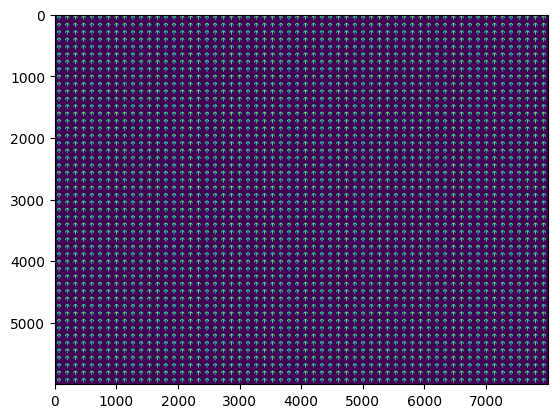

(6000, 8000)


In [15]:
#overview_fine = load_mask('tunnels_v0-7_large',crop = False, invert = True)
overview_fine = load_mask('Anchs_60um',crop = False, invert = False)
print(overview_fine.shape)

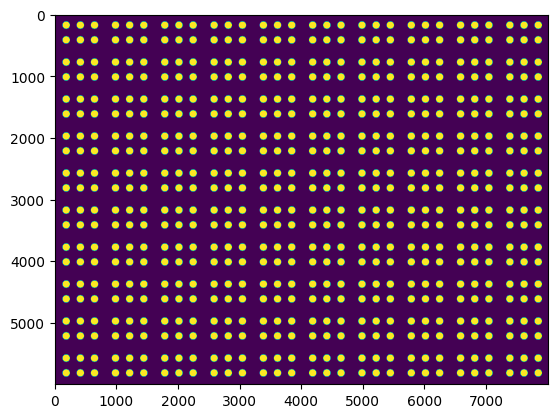

(6000, 8000)


In [16]:
#overview_fine = load_mask('tunnels_v0-7_large',crop = False, invert = True)
overview_fine = load_mask('Pancakes_DMD_Fov',crop = False, invert = False)
print(overview_fine.shape)

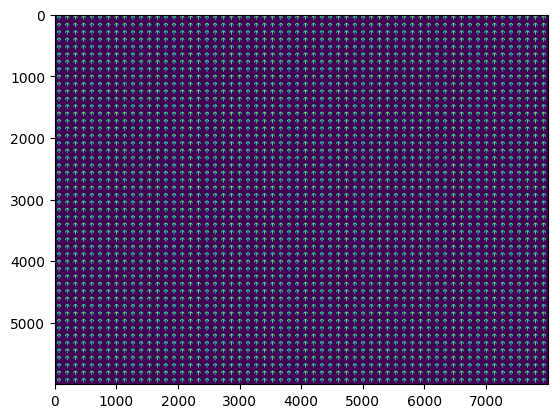

(6000, 8000)


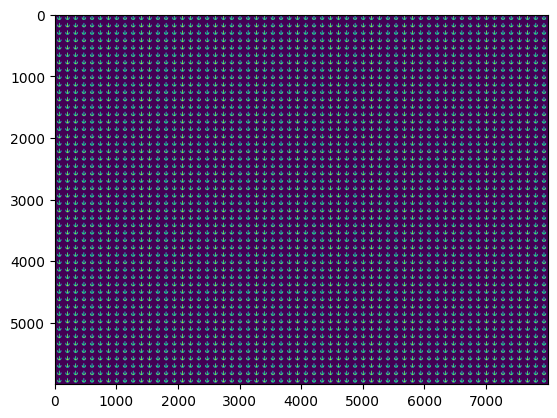

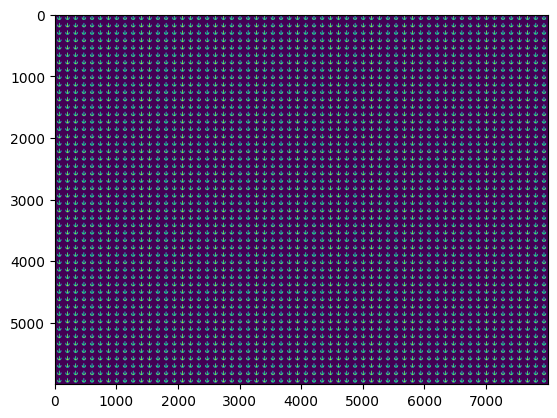

In [21]:
single_pattern = load_mask('Anchs_60um',crop = False, invert = False)
print(overview_fine.shape)
tiles = tile_array_single_pattern(single_pattern)
plt.imshow(tiles[4][::,::-1])
plt.show()
plt.imshow(tiles[1][::,::-1])
plt.show()

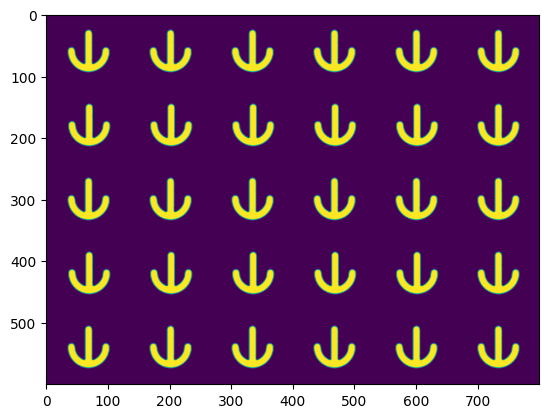

In [23]:
tiles = tile_array(overview_fine)
#for tile in range(len(tiles)):
    #plt.imshow(tiles[tile][::,::-1])
    #plt.show()

plt.imshow(tiles[1][::,::-1])
plt.show()


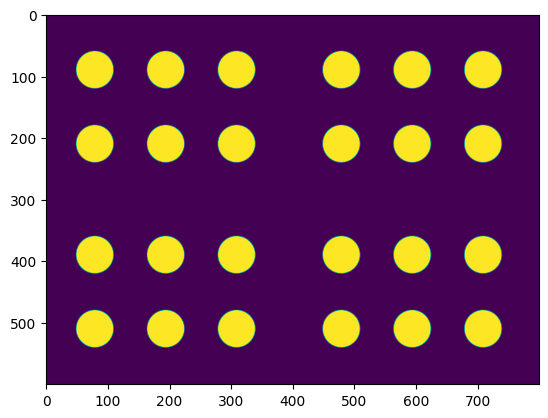

In [43]:
from skimage.transform import rescale

# Assuming tiles[1] is your image
tiles = tile_array(overview_fine)

# Rescale the image by half
rescaled_image = rescale(tiles[1][::,::-1], 0.5, mode='reflect')

plt.imshow(rescaled_image)
plt.show()

In [ ]:
viewer.add_labels(tiles[3])

In [19]:
expose_UV = preset(core)
# 555/25 with same filterwheel as H2B or 575 with 2/2
expose_UV.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",1],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "1"],#2 
    ["Wheel-C", "State", 1],# could also use 1 # standard  2
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Violet_Level",100] #25
]
expose_UV.camera_exposure_time = 100 #150
expose_UV.dmd_exposure_time = 2000
expose_UV.name = 'expose_UV'
expose_UV.apply(core)
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 1
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 1
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Violet_Level to 100


In [31]:
expose_UV.camera_exposure_time = int(18) #20
magnification = 20


y_offset = 20/magnification*485
x_offset = 20/magnification*655

point = core.get_xy_stage_position()
x_pos = point.get_x()
y_pos = point.get_y()
grid_height = 10
grid_width = 10

tile_id = 0

pos = stage_position(x_pos,y_pos,None)
fov_start = FOV(core, pos, 'treatment', 2,  10, 10,10)
fov = fov_start
with tqdm(total=grid_width*grid_height) as pbar:
    for col in range(grid_width):
        for row in range(grid_height):
            y_pos_new = y_pos+(row*y_offset)
            x_pos_new = x_pos+(col*x_offset)
            pos = stage_position(x_pos_new,y_pos_new,None)
            fov = FOV(core, pos, 'treatment', 2,  10, 10,10)

            # if np.max(tiles[tile_id])>0:  #only image if non-empty
            if(True):
                fov.move_stage_to_fov()
                stim_img = acq_mask(tiles[tile_id], expose_UV, dmd)
                #stim_img = acq_mask(mask_04, expose_UV, dmd)
                #stim_img = acq_mask(tiles[tile_id], expose_UV, dmd)
                #stim_img = acq_mask(donut, expose_UV, dmd)

                #plt.imshow(stim_img)
                #plt.show()

            #prepare for the next tile
            tile_id += 1

            y_pos_new = y_pos+((row+1)*y_offset)
            x_pos_new = x_pos+((col+1)*x_offset)

            pbar.update(1)
            #time.sleep(0.5)

# move back to beginnning      
fov_start.move_stage_to_fov() 

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


In [28]:
core.get_property('TIScope','DriverVersion')

'micusb.sys 3.0.1.9'

In [29]:
core.get_property('TIScope','FirmwareVersion')

'Ti-E V5.50'

In [30]:
core.get_property('TIScope','SoftwareVersion')

'4.4.1.728'

check_RED
stopping threads
Error when applying setting. Retry nb. 0.
starting threads...
Worker started: append_img
Worker started: yield_img
stopping threads
acquisition done
starting threads...
Worker started: append_imgWorker started: yield_img

stopping threads
acquisition done
starting threads...
Worker started: append_img
Worker started: yield_img
check_RED
stopping threads
acquisition done
starting threads...
Worker started: append_img
Worker started: yield_img
stopping threads
acquisition done
starting threads...
Worker started: append_img
Worker started: yield_img
stopping threads
acquisition done
